# Neural Collaborative Filltering

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1951167402041007287
 xla_global_id: -1]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, BatchNormalization, Dropout, Multiply
from keras.models import Model
from keras.optimizers import Adam

### 데이터 테이블 생성

In [3]:
table_df = pd.read_csv('../../data/ulsan_attraction_table.csv')
table_df

,place_id,u_id,user_id,score,comment,p_id
0,가지산 입석대,0,김호영(황소바위),5,NaN,248
1,가지산 입석대,1,기회란,4,NaN,248
2,가지산 입석대,2,손영진(산동무),5,NaN,248
3,가지산,0,김호영(황소바위),5,NaN,16
4,가지산,3,여름햇살,5,계단과 가파른 길이 많아 힘은 들지만 정상에서 바라보는 영남알프스의 풍경 값으로는 ...,16
...,...,...,...,...,...,...
15400,해파랑길 4코스,8870,👏👏👏,5,중간중간 길 표시가 잘안되어있어요ㅠㅠ 동해 해안가 따라 걷는 길 좋아요,130
15401,해파랑길 7코스,8877,김봉수,3,"해파랑길7코스, 상행길의 마지막부분인 아신길 코스가 있다. 아산길은 자전거길과 도보...",124
15402,해파랑길 8코스,8877,김봉수,5,울산지역 해파랑길 코스중 가장 좋은 코스입니다. 특히 염포산의 벗꽃은 정말 매력적입...,156
15403,해파랑길 9코스,8877,김봉수,4,현대중공업 인근의 도심과 봉대산을 거쳐 해안가를 걷는 코스입니다. 울산지역은 이정표...,199


In [4]:
print(table_df.isnull().sum())
table_df.drop(columns='comment', inplace=True)
table_df.dropna(axis=0, how='any', inplace=True)

place_id       0
u_id           0
user_id        0
score          0
comment     4857
p_id           0
dtype: int64


In [5]:
table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15405 entries, 0 to 15404
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   place_id  15405 non-null  object
 1   u_id      15405 non-null  int64 
 2   user_id   15405 non-null  object
 3   score     15405 non-null  int64 
 4   p_id      15405 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 601.9+ KB


In [6]:
data_df = table_df[['u_id', 'p_id', 'score']]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15405 entries, 0 to 15404
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   u_id    15405 non-null  int64
 1   p_id    15405 non-null  int64
 2   score   15405 non-null  int64
dtypes: int64(3)
memory usage: 361.2 KB


### Train, Test split

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_df, test_size=0.2, shuffle=True, random_state=42)

In [8]:
# n_users = data_df.u_id.unique().shape[0]
# n_items = data_df.p_id.unique().shape[0]
n_users = data_df.u_id.max() + 1
n_items = data_df.p_id.max() + 1
print(n_users, n_items)

9153 495


In [9]:
tf.keras.backend.clear_session()

### callback

In [10]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './checkpoint',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
)

### Model

In [11]:
latent_dim = 100 ## 잠재요인

# Define inputs
item_input = Input(shape=[1],name='item-input')
user_input = Input(shape=[1], name='user-input')
# User embedding for GMF
gmf_user_embedding = Embedding(n_users, latent_dim, input_length=user_input.shape[1])(user_input)
gmf_user_embedding = Flatten()(gmf_user_embedding)

# Item embedding for GMF
gmf_item_embedding = Embedding(n_items, latent_dim, input_length=item_input.shape[1])(item_input)
gmf_item_embedding = Flatten()(gmf_item_embedding)

# User embedding for MLP
mlp_user_embedding = Embedding(n_users, 50, input_length=user_input.shape[1])(user_input)
mlp_user_embedding = Flatten()(mlp_user_embedding)

# Item embedding for MLP
mlp_item_embedding = Embedding(n_items, 50, input_length=item_input.shape[1])(item_input)
mlp_item_embedding = Flatten()(mlp_item_embedding)

# GMF layers
gmf_mul =  Multiply()([gmf_user_embedding, gmf_item_embedding])

# MLP layers
mlp_concat = Concatenate()([mlp_user_embedding, mlp_item_embedding])
mlp_dropout = Dropout(0.2)(mlp_concat)

# Layer1
fc_1 = Dense(units=100, activation='relu', name='mlp_layer1')(mlp_dropout)  
fc_1_dropout = Dropout(rate=0.2, name='dropout1')(fc_1)                    
fc_1_bn = BatchNormalization(name='batch_norm1')(fc_1_dropout)            

# Layer2
fc_2 = Dense(units=50, activation='relu', name='mlp_layer2')(fc_1_bn)  
fc_2_dropout = Dropout(rate=0.2, name='dropout2')(fc_2)                        
fc_2_bn = BatchNormalization(name='batch_norm2')(fc_2_dropout)                

# Layer3
fc_3 = Dense(units=10, activation='relu', name='mlp_layer3')(fc_2_bn)

# merge GMF + MLP
merged_vector = tf.keras.layers.concatenate([gmf_mul, fc_3])

# Output layer
output = Dense(1, kernel_initializer='lecun_uniform', name='output_layer')(merged_vector)

model = Model([user_input, item_input], output)
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        457650      ['user-input[0][0]']             
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 50)        24750       ['item-input[0][0]']             
                                                                                              

### Model Trainning

In [12]:
history = model.fit(x=[train.u_id, train.p_id],y= train.score, validation_split=0.2, epochs=50, verbose=1, callbacks=[earlystopping])

Epoch 1/50
309/309 [==============================] - 7s 19ms/step - loss: 2.2454 - val_loss: 1.1084
Epoch 2/50
309/309 [==============================] - 5s 18ms/step - loss: 0.6389 - val_loss: 0.9026
Epoch 3/50
309/309 [==============================] - 5s 17ms/step - loss: 0.4253 - val_loss: 0.8956
Epoch 4/50
309/309 [==============================] - 5s 17ms/step - loss: 0.2525 - val_loss: 0.9738
Epoch 5/50
309/309 [==============================] - 6s 18ms/step - loss: 0.1507 - val_loss: 0.8803
Epoch 6/50
309/309 [==============================] - 7s 21ms/step - loss: 0.1129 - val_loss: 0.8923
Epoch 7/50
309/309 [==============================] - 7s 22ms/step - loss: 0.0881 - val_loss: 0.8840
Epoch 8/50
309/309 [==============================] - 7s 24ms/step - loss: 0.0731 - val_loss: 0.8885
Epoch 9/50
309/309 [==============================] - 7s 22ms/step - loss: 0.0624 - val_loss: 0.8782
Epoch 10/50
309/309 [==============================] - 7s 23ms/step - loss: 0.0574 - val_lo

### Loss graph

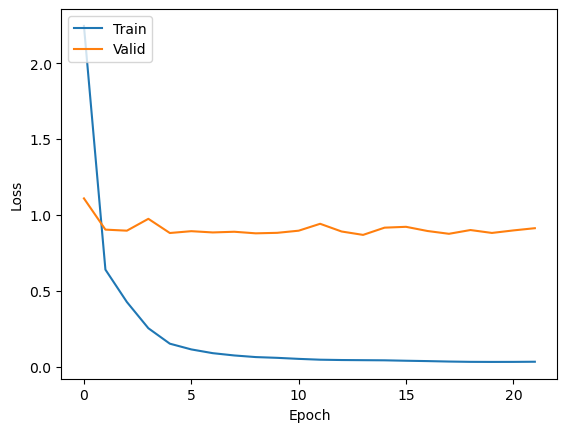

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
plt.show()

In [14]:
model.evaluate([test.u_id, test.p_id], test.score)

97/97 [==============================] - 0s 2ms/step - loss: 0.8825


0.8825152516365051

### 성능평가(RMSE)

In [15]:
from sklearn.metrics import mean_squared_error
y_prob = model.predict([test.u_id, test.p_id])
y_true = test.score
mean_squared_error(y_true, y_prob)**0.5

97/97 [==============================] - 0s 1ms/step


0.939422760685962

In [16]:
model.save("../model/attraction_NCF_2.h5")


### Hit Rate(적중률) 평가

In [17]:
loaded_model = tf.keras.models.load_model("../model/attraction_NCF_2.h5")

In [18]:
uid_list = [1137, 56, 1596, 892, 1146, 836, 1198, 455, 8, 37]
uid_list = np.array(uid_list)

In [19]:
def calc_hit(model, uid_list, data_df, top_n):
    hit = []
    # pid_list = np.array(data_df.p_id.unique())
    for u_id in uid_list:
        p_id_list = np.array(list(set(data_df['p_id'][data_df['u_id']==u_id])))
        pred_df = pd.DataFrame(columns=['u_id', 'p_id', 'score'])
        for p_id in p_id_list:
            pred = model.predict([np.array([u_id]), np.array([p_id])])
            new_data = pd.DataFrame({'u_id': [u_id], 'p_id': [p_id], 'score': [pred]})
            pred_df = pd.concat([pred_df, new_data], axis=0, names=['u_id', 'p_id', 'rating'], ignore_index=True)
            recom_df = pred_df.sort_values(by=['score'], ascending=False)[:top_n]
            actual_df = data_df[data_df.u_id == u_id].sort_values(by=['score'], ascending=False)
            actual_df = actual_df[actual_df.score>=3][:top_n]
            
        for item in set(recom_df['p_id']):
            if int(item) in list(set(actual_df['p_id'])):
                hit.append(1)
            else:
                hit.append(0)
    return np.mean(hit)

In [20]:
hit_rate = calc_hit(loaded_model, uid_list, data_df, 10)

1/1 [==============================] - 0s 23ms/step


In [21]:
print('hit rate:', hit_rate)

hit rate: 0.83


In [22]:
hit_rate = calc_hit(loaded_model, uid_list, data_df, 15)

1/1 [==============================] - 0s 21ms/step


In [23]:
print('hit rate:', hit_rate)

hit rate: 0.9856115107913669


In [24]:
hit_rate = calc_hit(loaded_model, uid_list, data_df, 20)

1/1 [==============================] - 0s 19ms/step


In [25]:
print('hit rate:', hit_rate)

hit rate: 0.9856115107913669
